In [3]:
! pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 46.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 43.6 MB/s eta 0:00:0000:0100:01


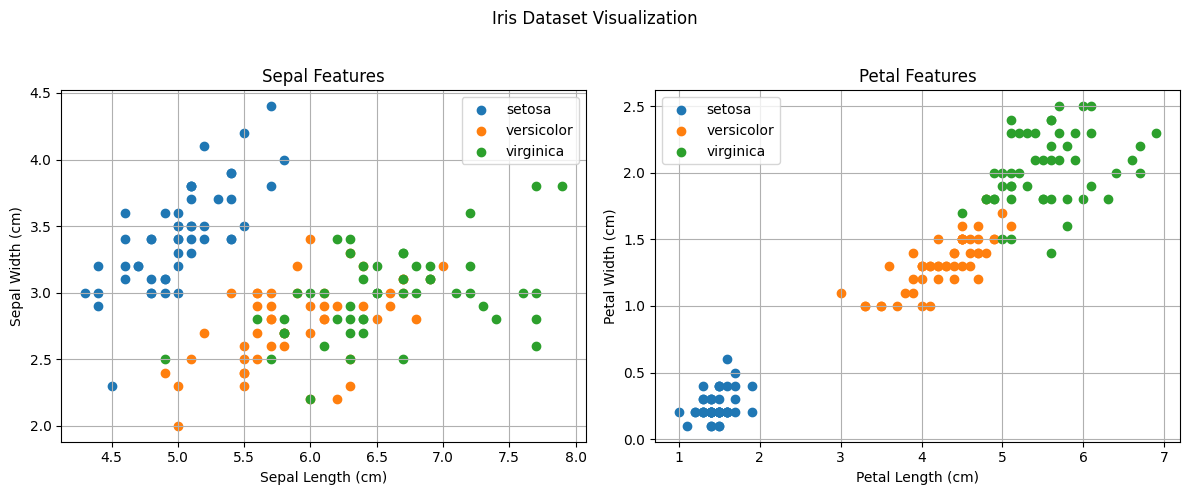

Starting training...
Epoch [100/1000], Loss: 0.3223
Epoch [200/1000], Loss: 0.2006
Epoch [300/1000], Loss: 0.1860
Epoch [400/1000], Loss: 0.1782
Epoch [500/1000], Loss: 0.1716
Epoch [600/1000], Loss: 0.1656
Epoch [700/1000], Loss: 0.1602
Epoch [800/1000], Loss: 0.1553
Epoch [900/1000], Loss: 0.1508
Epoch [1000/1000], Loss: 0.1468
Training finished.

--- Evaluation on Test Set ---
Correct Predictions: 24/30
Accuracy: 80.00%

Example Predictions:
Sample 1: Actual='versicolor', Predicted='versicolor'
Sample 2: Actual='setosa', Predicted='setosa'
Sample 3: Actual='virginica', Predicted='versicolor'
Sample 4: Actual='versicolor', Predicted='virginica'
Sample 5: Actual='versicolor', Predicted='versicolor'


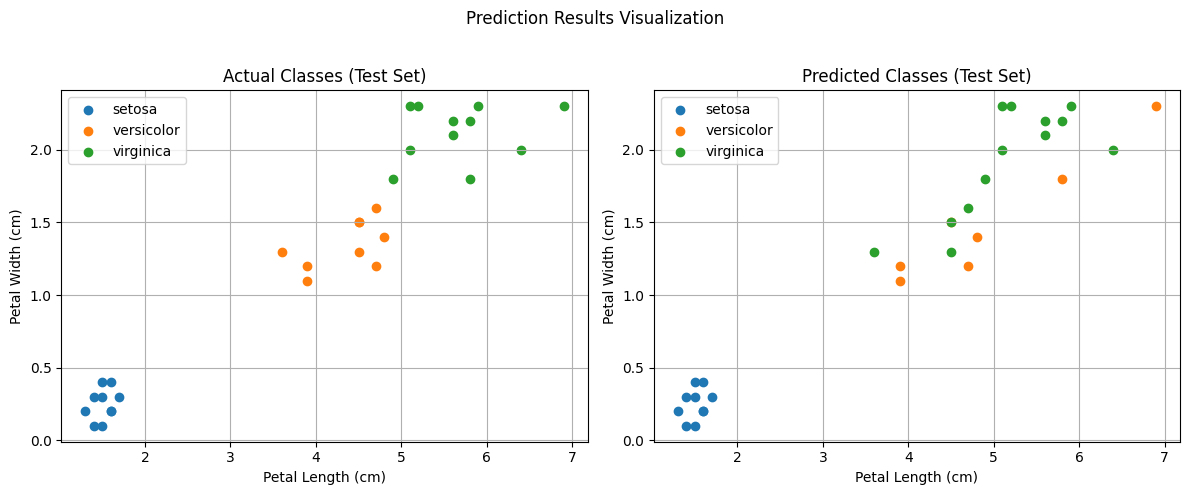

In [4]:
import torch
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# 1. Load and Preprocess Data
# Load the Iris dataset from scikit-learn
iris = load_iris()
X = iris.data
y = iris.target

# 1.5 Visualize the data
plt.figure(figsize=(12, 5))

# Plot Sepal Length vs Sepal Width
plt.subplot(1, 2, 1)
for i, target_name in enumerate(iris.target_names):
    # Select data for the current class
    plt.scatter(X[y == i, 0], X[y == i, 1], label=target_name)
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.title('Sepal Features')
plt.legend()
plt.grid(True)

# Plot Petal Length vs Petal Width
plt.subplot(1, 2, 2)
for i, target_name in enumerate(iris.target_names):
    # Select data for the current class
    plt.scatter(X[y == i, 2], X[y == i, 3], label=target_name)
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Petal Features')
plt.legend()
plt.grid(True)

plt.suptitle('Iris Dataset Visualization')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# One-hot encode the target labels for the training set
# The output of our linear model will have 3 values (one for each class)
# We use one-hot encoding to create a target tensor of the same shape.
n_classes = len(np.unique(y))
y_train_one_hot = torch.nn.functional.one_hot(y_train_tensor, num_classes=n_classes).float()

# 2. Manual Model Definition (without torch.nn)
# The input has 4 features (sepal length/width, petal length/width)
# The output has 3 classes (setosa, versicolor, virginica)
n_features = X_train.shape[1]

# Initialize weights and bias tensors.
# These are the parameters our model will learn.
# We set requires_grad=True to track gradients for them.
weights = torch.randn(n_features, n_classes, requires_grad=True)
bias = torch.zeros(n_classes, requires_grad=True)

# 3. Define Optimizer and Loss Function
learning_rate = 0.01
# We use the standard Stochastic Gradient Descent (SGD) optimizer
# It needs to know which tensors to update (our weights and bias)
optimizer = optim.SGD([weights, bias], lr=learning_rate)

# We will use Mean Squared Error (MSE) as our loss function.
# It measures the average squared difference between predictions and actual values.
def mse_loss(predictions, targets):
    return torch.mean((predictions - targets) ** 2)

# 4. Training Loop
epochs = 1000
print("Starting training...")
for epoch in range(epochs):
    # --- Forward pass ---
    # Manually perform the linear regression operation: y = X * W + b
    predictions = X_train_tensor @ weights + bias

    # --- Calculate loss ---
    loss = mse_loss(predictions, y_train_one_hot)

    # --- Backward pass ---
    # Reset gradients from the previous step
    optimizer.zero_grad()
    # Compute gradients of the loss with respect to weights and bias
    loss.backward()

    # --- Update weights ---
    # Tell the optimizer to take a step based on the computed gradients
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("Training finished.")

# 5. Evaluation
# We don't need to track gradients during evaluation
with torch.no_grad():
    # Make predictions on the test set
    test_predictions = X_test_tensor @ weights + bias

    # The model outputs scores for each class.
    # We take the index of the highest score as the predicted class.
    _, predicted_classes = torch.max(test_predictions, 1)

    # Calculate accuracy
    correct_predictions = (predicted_classes == y_test_tensor).sum().item()
    total_predictions = y_test_tensor.size(0)
    accuracy = correct_predictions / total_predictions

    print("\n--- Evaluation on Test Set ---")
    print(f'Correct Predictions: {correct_predictions}/{total_predictions}')
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Example predictions
    print("\nExample Predictions:")
    for i in range(5):
        actual_class = iris.target_names[y_test_tensor[i]]
        predicted_class = iris.target_names[predicted_classes[i]]
        print(f"Sample {i+1}: Actual='{actual_class}', Predicted='{predicted_class}'")
    
    # 5.5 Visualize the predictions
    plt.figure(figsize=(12, 5))

    # Plot Actual classes
    plt.subplot(1, 2, 1)
    for i, target_name in enumerate(iris.target_names):
        # Select data for the current class from the test set
        indices = y_test == i
        plt.scatter(X_test[indices, 2], X_test[indices, 3], label=target_name)
    plt.xlabel('Petal Length (cm)')
    plt.ylabel('Petal Width (cm)')
    plt.title('Actual Classes (Test Set)')
    plt.legend()
    plt.grid(True)

    # Plot Predicted classes
    plt.subplot(1, 2, 2)
    # Convert predicted_classes tensor to numpy for easier indexing
    predicted_classes_np = predicted_classes.numpy()
    for i, target_name in enumerate(iris.target_names):
        # Select data for the current predicted class from the test set
        indices = predicted_classes_np == i
        plt.scatter(X_test[indices, 2], X_test[indices, 3], label=target_name)
    plt.xlabel('Petal Length (cm)')
    plt.ylabel('Petal Width (cm)')
    plt.title('Predicted Classes (Test Set)')
    plt.legend()
    plt.grid(True)

    plt.suptitle('Prediction Results Visualization')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
